# imports and settings

In [1]:
import numpy as np
import anndata as ad
import scanpy as sc
import palettable
import time
import seaborn as sns
import os

In [2]:
%matplotlib inline

# sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap
# sc.set_figure_params(fontsize=20)


sns.set_style('white')
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 2}

# matplotlib.rc('font', **font)
# matplotlib.rcParams.update({'font.size': 2})

import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title







# function

In [3]:
from sklearn.preprocessing import *
import scanpy as sc
import numpy as np
import time
from skimage.color import rgb2lab, lab2rgb
from scipy.sparse import issparse 
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import anndata as ad
import matplotlib.pyplot as plt

def SOViewer_UMAP(adata,pca=100,dot_size=0.001,marker='o',plot_cluster=None,save=None):
    # 输入：
    # adata(附带spatial, 处理过后的X)
    # sample_rate：默认0.01


    print('projecting all data into PCA space...')
    time_start=time.time()
    
    sc.pp.pca(adata,n_comps=pca)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata,n_components=3)
    test_embedding = adata.obsm['X_umap']
    time_end=time.time()
    print('projecting time cost',time_end-time_start,'s')

    print('generating color coding...')
    rgb = MinMaxScaler(clip=True).fit_transform(test_embedding)
    lab = np.zeros_like(rgb)
    lab[:,0] = MinMaxScaler(feature_range=(0, 100),clip=True).fit_transform(rgb[:,0][:,None])[:,0]
    lab[:,1] = MinMaxScaler(feature_range=(-128, 127),clip=True).fit_transform(rgb[:,1][:,None])[:,0]
    lab[:,2] = MinMaxScaler(feature_range=(-128, 127),clip=True).fit_transform(rgb[:,2][:,None])[:,0]
    lab = lab2rgb(lab)

    c = lab
    print(c.max(),c.min())
    plt.scatter(x=adata.obsm['spatial'][:,0],y=adata.obsm['spatial'][:,1],c=c,s=dot_size,edgecolors='none',marker=marker)
    plt.gca().set_aspect('equal', adjustable='box')
#     plt.title('lab')
    plt.title('NO sampling, Umap, LAB')

    if save is None:
        plt.show()
    else:
        plt.savefig('{0}_{1}.pdf'.format(save,'LAB'),format='pdf')

    c = rgb
    print(c.max(),c.min())
    
    plt.scatter(x=adata.obsm['spatial'][:,0],y=adata.obsm['spatial'][:,1],c=c,s=dot_size,edgecolors='none',marker=marker)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('NO sampling, Umap, RGB')
    if save is None:
        plt.show()
    else:
        plt.savefig('{0}_{1}.pdf'.format(save,'RGB'),format='pdf')
    
    if plot_cluster is None:
        return
    c = np.array(adata.obs[plot_cluster]).astype('int')
    
    plt.scatter(x=adata.obsm['spatial'][:,0],y=adata.obsm['spatial'][:,1],c=c,s=dot_size,edgecolors='none',marker=marker)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('cluster on spatial')
    plt.show()
        


# data loading

In [4]:
example_path = '/home/yzy/PUBDT/st/IMS/OtherMaldi/'
data_name = 'GruppeB_162x151_65umE0'
data_file = '{0}/data/{1}.imzML'.format(example_path,data_name)

output_image_root = '/home/yzy/PUBDT/st/IMS/OtherMaldi/output_image'
output_image_folder = '{0}/{1}'.format(output_image_root,data_name)

output_view_folder = '/home/yzy/PUBDT/st/IMS/OtherMaldi/output_view'

In [5]:
isExist = os.path.exists(output_image_folder)

if not isExist:
    os.makedirs(output_image_folder)
  # Create a new directory because it does not exist 
    print("{0} does not exist, created one.".format(output_image_folder))
else:
    print('{0} existed.'.format(output_image_folder))

/home/yzy/PUBDT/st/IMS/OtherMaldi/output_image/GruppeB_162x151_65umE0 does not exist, created one.


In [8]:
from pyimzml.ImzMLParser import ImzMLParser

p = ImzMLParser(data_file)

mzs_list = []
spatial_list = []
for idx, (x,y,z) in enumerate(p.coordinates):
    
    mzs, intensities = p.getspectrum(idx)
#     break
    mzs_list.extend(mzs)
    spatial_list.append([x,y])
spatial_list = np.array(spatial_list)
    

/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/pyimzml/ontology/ontology.py:94: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  % (accession, raw_name, name)
/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/pyimzml/ontology/ontology.py:94: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  % (accession, raw_name, name)
/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/pyimzml/ontology/ontology.py:94: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  % (accession, raw_name, name)
/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/pyimzml/ontology/ontology.py:94: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  % (accession, raw_name, name)
/home

In [11]:
mzs_int_list = np.unique(np.floor((mzs_list)))

In [14]:
mzs_int_reverse_dict = dict(zip(mzs_int_list,np.arange(len(mzs_int_list))))

In [15]:
X = np.zeros(shape=(spatial_list.shape[0],len(mzs_int_list)))

In [16]:
for idx, (x,y,z) in enumerate(p.coordinates):
    
    mzs, intensities = p.getspectrum(idx)
    for i in range(len(mzs)):
        cur_mz = mzs[i]
        cur_intensity = intensities[i]
        cur_mz_int = np.floor(cur_mz)
        X[idx,mzs_int_reverse_dict[cur_mz_int]] += cur_intensity
        


In [17]:
adata = ad.AnnData(X)
adata.var_names = mzs_int_list.astype('str')
adata.obsm['spatial'] = spatial_list

In [ ]:
adata.write_h5ad('')

# ploting

### scatter version

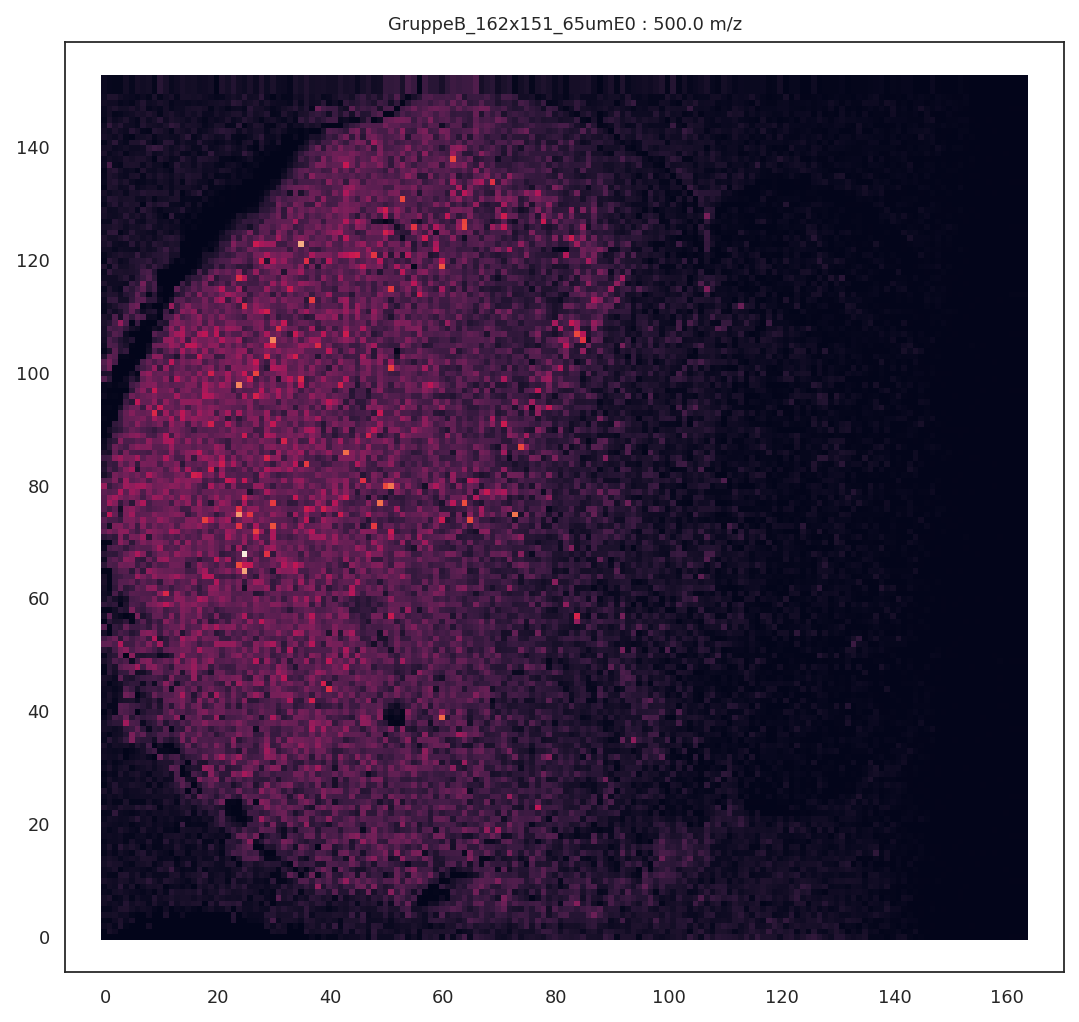

In [18]:
plot_var = '500.0'
x_array = adata.obsm['spatial'][:,0]
y_array = adata.obsm['spatial'][:,1]

c = np.array(adata[:,plot_var].X).reshape(-1,)
dot_size = 80
marker = 's'
save = None

plt.scatter(x=x_array,y=y_array,c=c,s=dot_size,edgecolors='none',marker=marker)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('{0} : {1} m/z'.format(data_name,plot_var))
if save is None:
    plt.show()
else:
    plt.savefig('{0}_{1}.pdf'.format(save,'RGB'),format='pdf')


### image version

In [100]:
y_array.max()

40

(-0.5, 161.5, 150.5, -0.5)

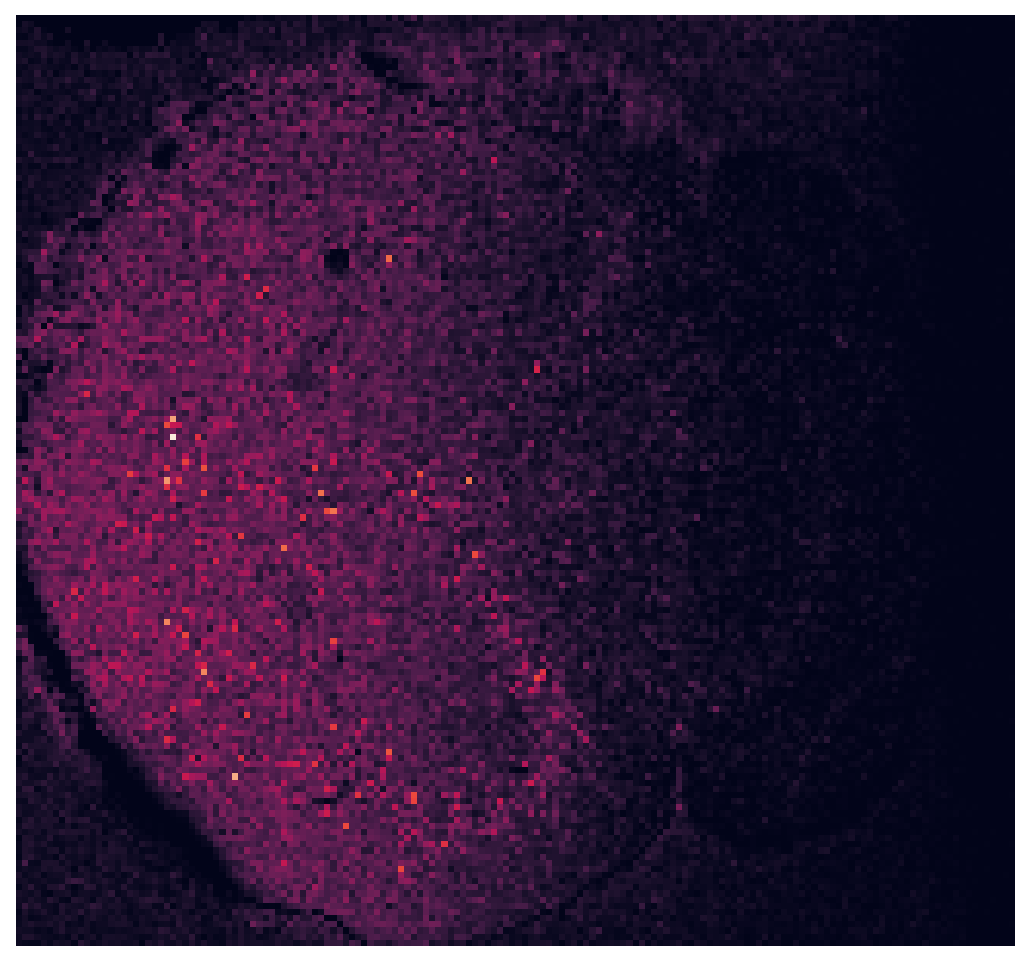

In [21]:
plot_var = '500.0'
save = None

x_array = adata.obsm['spatial'][:,0]
y_array = adata.obsm['spatial'][:,1]
shape_x = x_array.max()
shape_y = y_array.max()

img = np.array(adata[:,plot_var].X).reshape(shape_y,shape_x)
plt.imshow(img)
plt.axis('off')
# plt.savefig('{0}/{1}.png'.format(save,plot_var),format='png')


KeyboardInterrupt: 

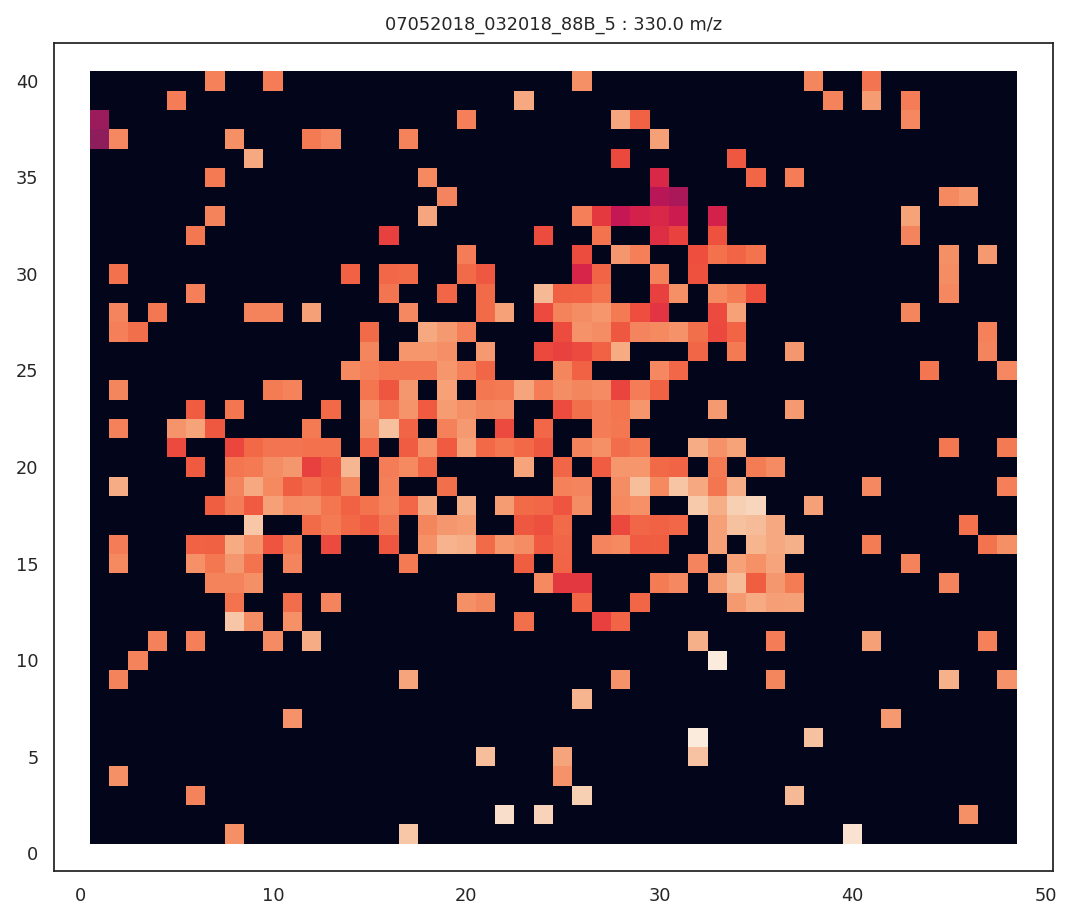

In [85]:
x_array = adata.obsm['spatial'][:,0]
y_array = adata.obsm['spatial'][:,1]
dot_size = 80
marker = 's'
save = output_image_folder
for plot_var in adata.var_names:
    c = np.array(adata[:,plot_var].X).reshape(-1,)
    
    plt.scatter(x=x_array,y=y_array,c=c,s=dot_size,edgecolors='none',marker=marker)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('{0} : {1} m/z'.format(data_name,plot_var))
    if save is None:
        plt.show()
    else:
        plt.savefig('{0}/{1}.png'.format(save,plot_var),format='png')

# generating image for all data

In [26]:
#     data_name = '07052018_032018_88B_5'
def save_desi_imaging_data(data_name):
    print('processing data: {0}'.format(data_name))
    # specify data paths
    example_path = '/home/yzy/PUBDT/st/IMS/OtherMaldi'
    data_file = '{0}/data/{1}.imzML'.format(example_path,data_name)

    output_image_root = '/home/yzy/PUBDT/st/IMS/OtherMaldi/output_image'
    output_image_folder = '{0}/{1}'.format(output_image_root,data_name)

    output_view_folder = '/home/yzy/PUBDT/st/IMS/OtherMaldi/output_view'

    output_h5ad_folder = '/home/yzy/PUBDT/st/IMS/OtherMaldi/h5ad'
    isExist = os.path.exists(output_image_folder)

    if not isExist:
        os.makedirs(output_image_folder)
      # Create a new directory because it does not exist 
        print("{0} does not exist, created one.".format(output_image_folder))
    else:
        print('{0} existed.'.format(output_image_folder))


    # generate adata
    from pyimzml.ImzMLParser import ImzMLParser

    p = ImzMLParser(data_file)

    mzs_list = []
    spatial_list = []
    for idx, (x,y,z) in enumerate(p.coordinates):

        mzs, intensities = p.getspectrum(idx)
        mzs_list.extend(mzs)
        spatial_list.append([x,y])
    spatial_list = np.array(spatial_list)

    mzs_int_list = np.unique(np.floor((mzs_list)))
    mzs_int_reverse_dict = dict(zip(mzs_int_list,np.arange(len(mzs_int_list))))
    X = np.zeros(shape=(spatial_list.shape[0],len(mzs_int_list)))
    for idx, (x,y,z) in enumerate(p.coordinates):

        mzs, intensities = p.getspectrum(idx)
        for i in range(len(mzs)):
            cur_mz = mzs[i]
            cur_intensity = intensities[i]
            cur_mz_int = np.floor(cur_mz)
            X[idx,mzs_int_reverse_dict[cur_mz_int]] += cur_intensity
    adata = ad.AnnData(X)
    adata.var_names = mzs_int_list.astype('str')
    adata.obsm['spatial'] = spatial_list
    adata.write_h5ad('{0}/{1}.h5ad'.format(output_h5ad_folder,data_name))
    # save imaging data
#     x_array = adata.obsm['spatial'][:,0]
#     y_array = adata.obsm['spatial'][:,1]
#     dot_size = 80
#     marker = 's'
#     save = output_image_folder
#     for plot_var in adata.var_names:
#         c = np.array(adata[:,plot_var].X).reshape(-1,)

#         plt.scatter(x=x_array,y=y_array,c=c,s=dot_size,edgecolors='none',marker=marker)
#         plt.gca().set_aspect('equal', adjustable='box')
#         plt.title('{0} : {1} m/z'.format(data_name,plot_var))
#         if save is None:
#             plt.show()
#         else:
#             plt.savefig('{0}/{1}.png'.format(save,plot_var),format='png')


            
#     save = output_image_folder
#     x_array = adata.obsm['spatial'][:,0]
#     y_array = adata.obsm['spatial'][:,1]
#     shape_x = x_array.max()
#     shape_y = y_array.max()
#     for plot_var in adata.var_names:
#         img = np.array(adata[:,plot_var].X).reshape(shape_y,shape_x)
#         plt.imshow(img)
#         plt.axis('off')
#         plt.savefig('{0}/{1}.png'.format(save,plot_var),format='png')


In [28]:
for file in os.listdir(example_path+'/data'):
    if not file.endswith('.ibd'):
        continue
    data_name = file[:-4]
    save_desi_imaging_data(data_name)
    

processing data: FW448i_330x282_FS_p05-2kDa_LM548_FP12_A14_R240k
/home/yzy/PUBDT/st/IMS/OtherMaldi/output_image/FW448i_330x282_FS_p05-2kDa_LM548_FP12_A14_R240k does not exist, created one.


/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/pyimzml/ontology/ontology.py:94: UserWarning: Accession MS:1000511 found with incorrect name "ms levelr". Updating name to "ms level".
  % (accession, raw_name, name)
/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/pyimzml/ontology/ontology.py:94: UserWarning: Accession MS:1000799 found with incorrect name "Custom RAW2IMZML conversion tool". Updating name to "custom unreleased software tool".
  % (accession, raw_name, name)


processing data: S1216_Kidneyplasticonly_260x175_30um_E25
/home/yzy/PUBDT/st/IMS/OtherMaldi/output_image/S1216_Kidneyplasticonly_260x175_30um_E25 existed.
processing data: GruppeC_165x189_50umE0
/home/yzy/PUBDT/st/IMS/OtherMaldi/output_image/GruppeC_165x189_50umE0 existed.
processing data: S655_WS22_320x200_15um_E110
/home/yzy/PUBDT/st/IMS/OtherMaldi/output_image/S655_WS22_320x200_15um_E110 existed.
processing data: GruppeB_162x151_65umE0
/home/yzy/PUBDT/st/IMS/OtherMaldi/output_image/GruppeB_162x151_65umE0 existed.


# processing

### clustering

In [50]:
sc.pp.calculate_qc_metrics(adata,inplace=True)

In [51]:
adata

AnnData object with n_obs × n_vars = 1920 × 1400
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'

In [52]:

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.louvain(adata)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


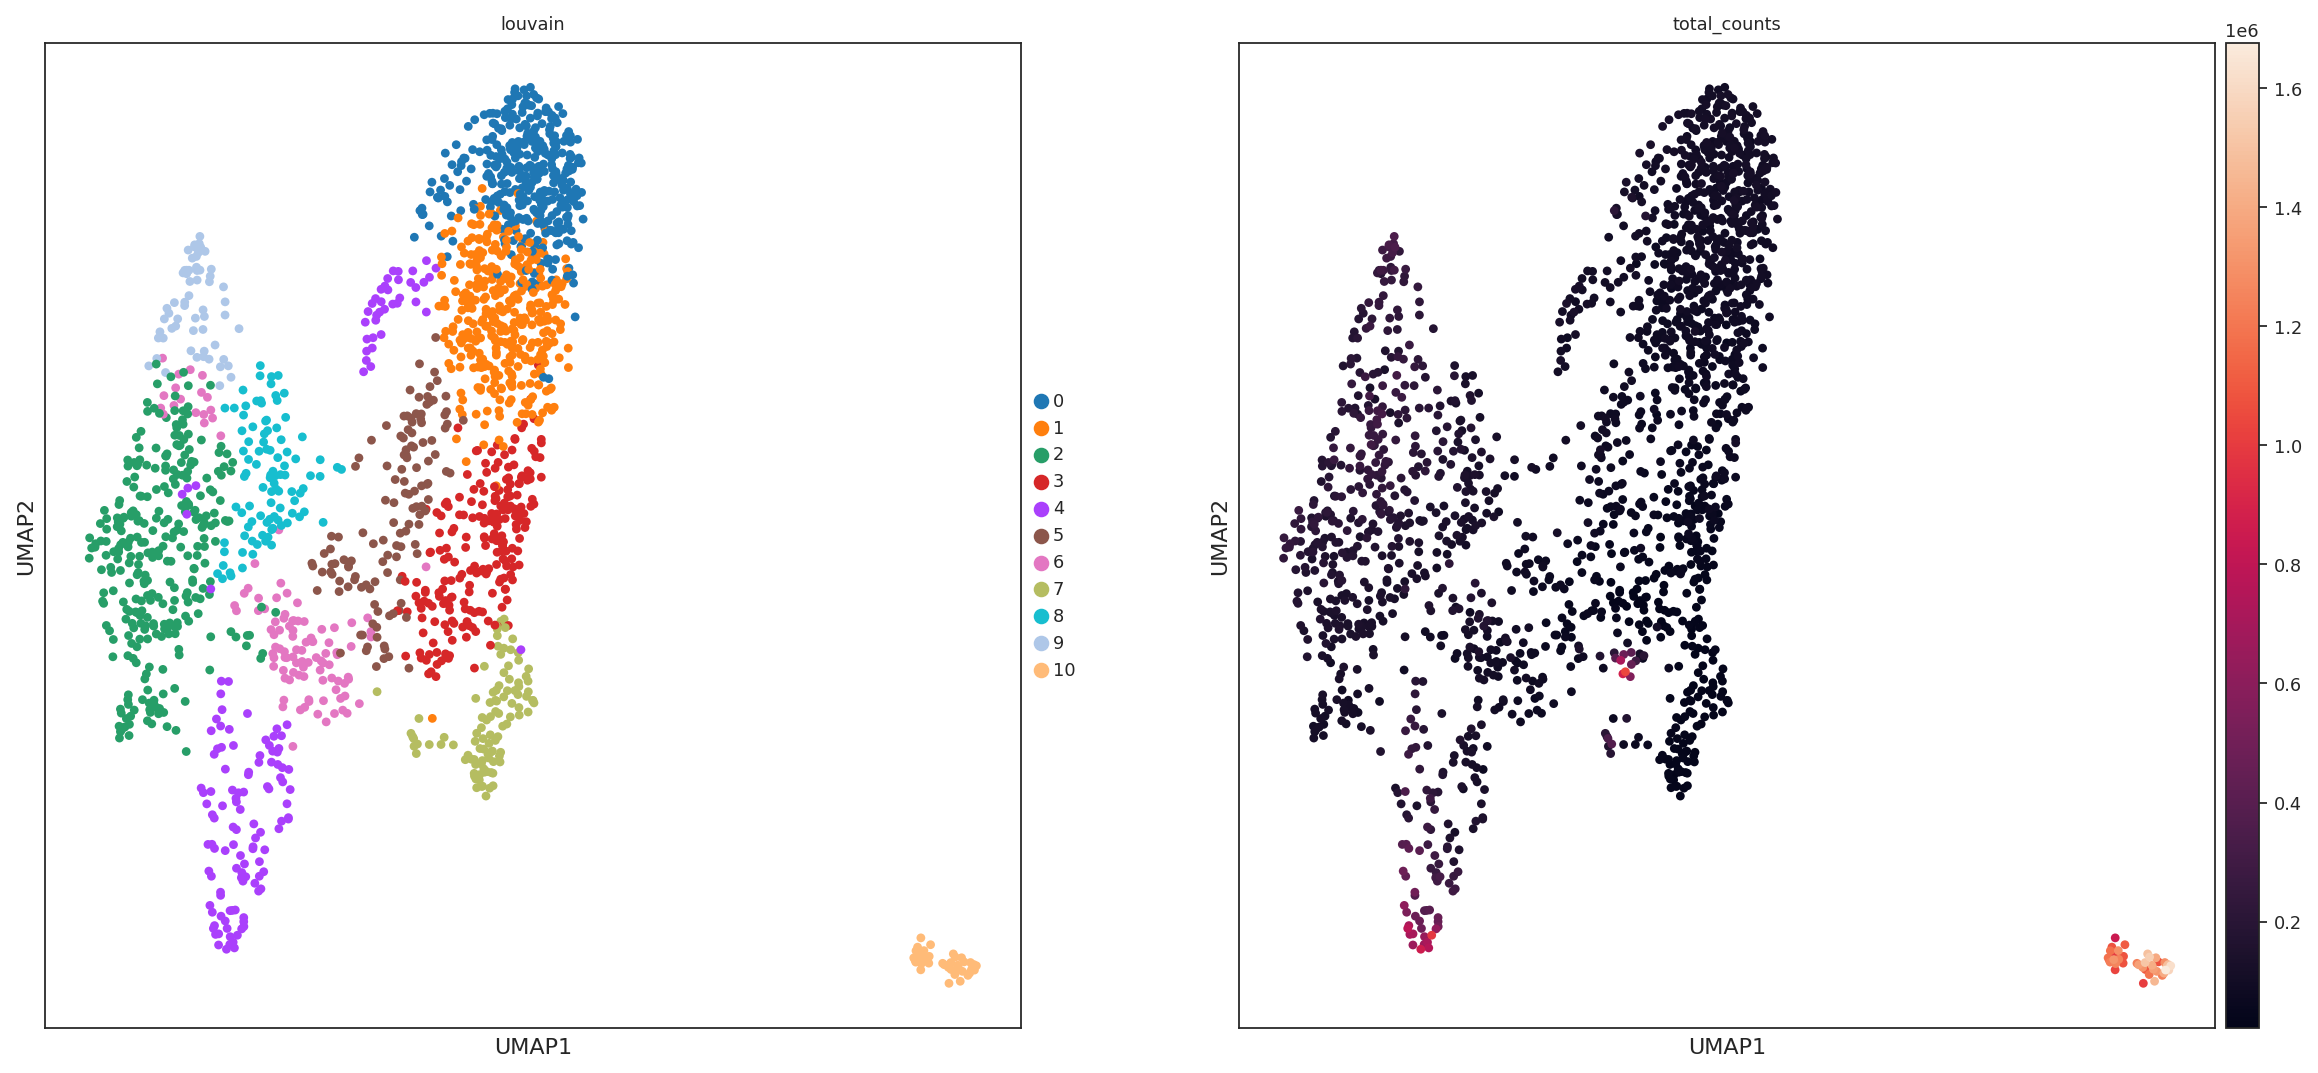

In [54]:
sc.pl.umap(adata,color=['louvain','total_counts'])

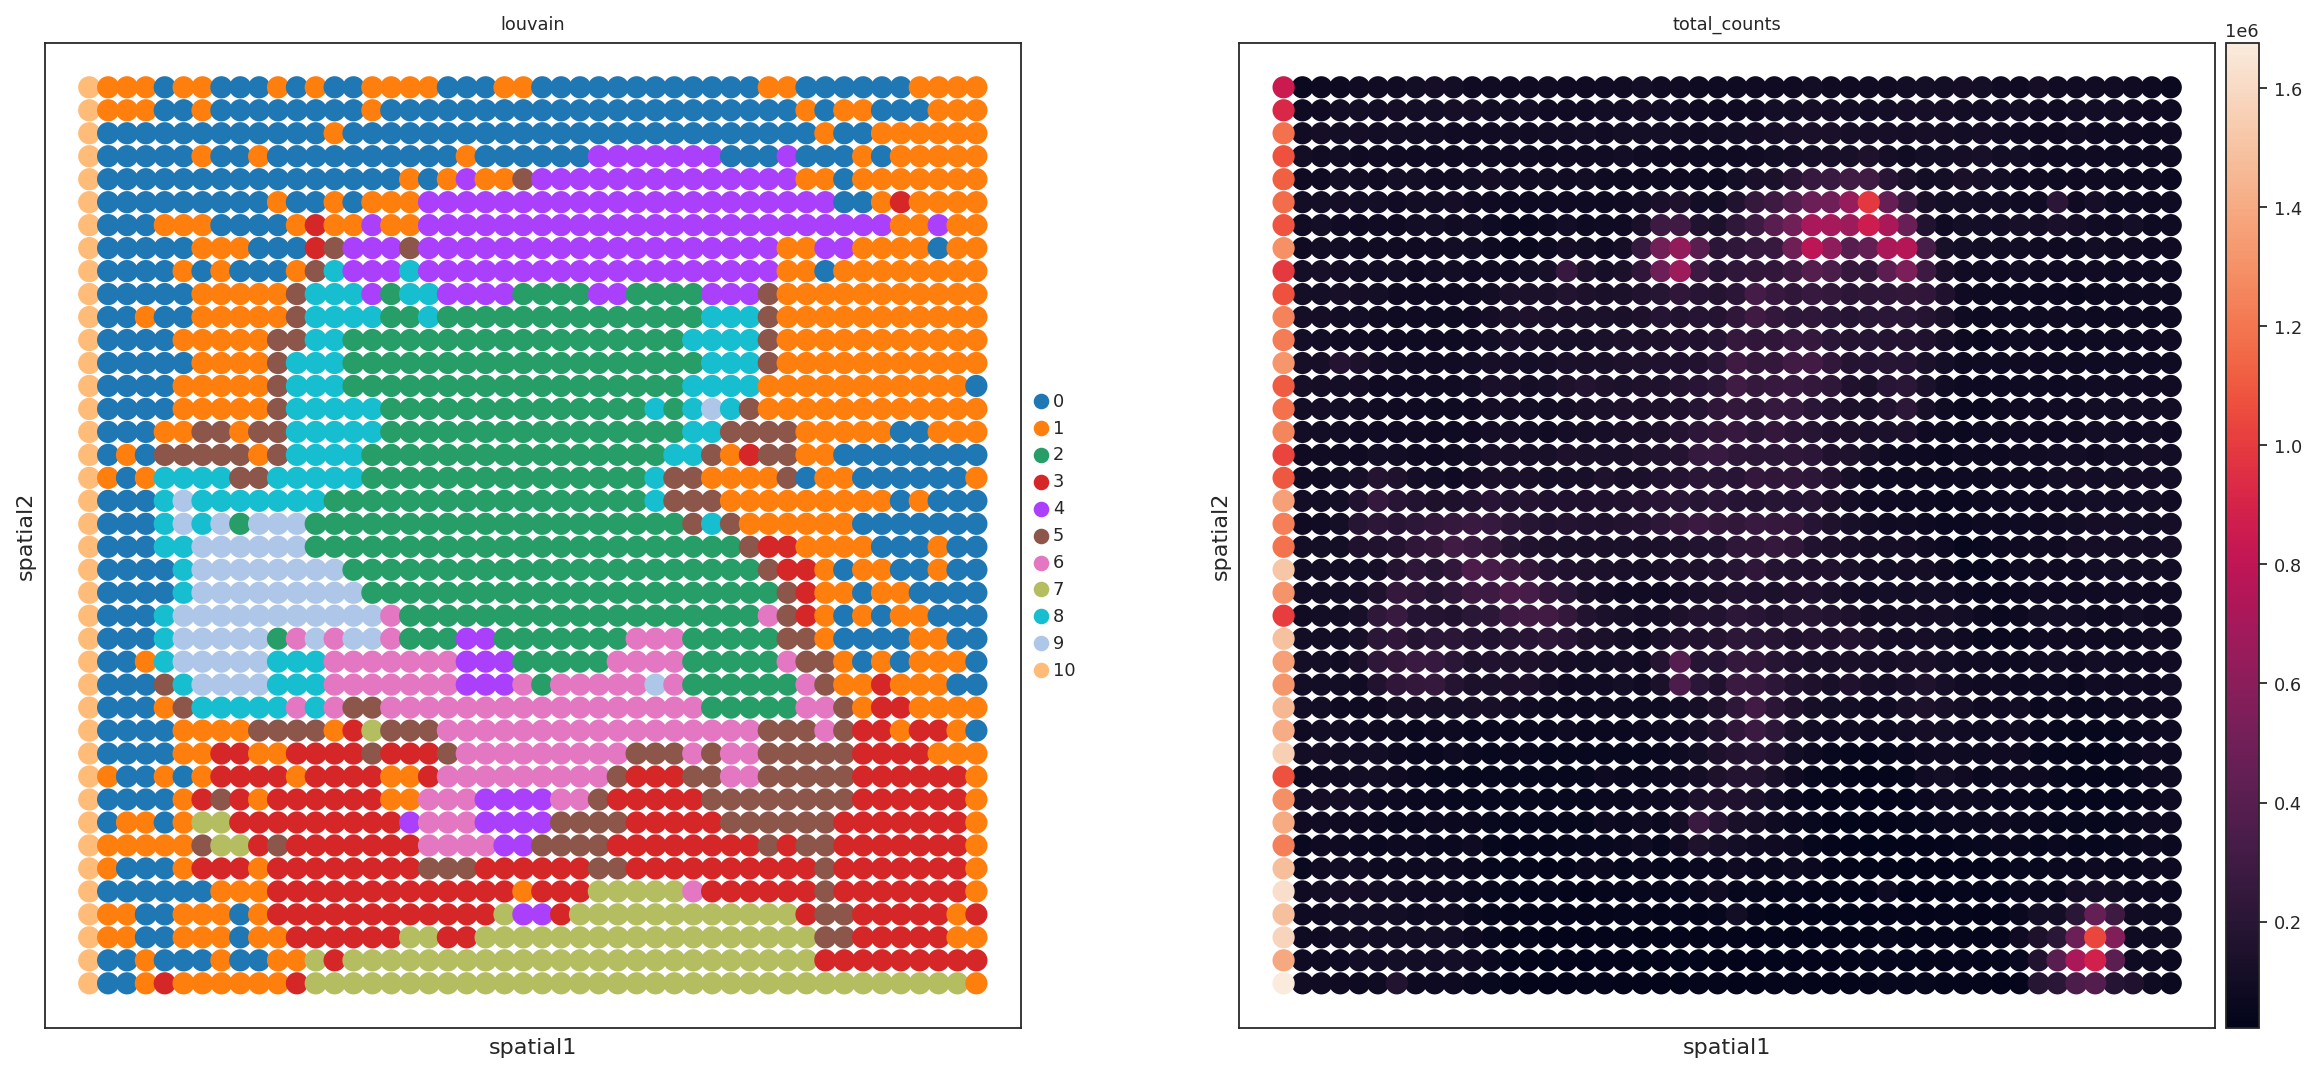

In [57]:
sc.pl.embedding(adata,basis='spatial',color=['louvain','total_counts'],size=400)

In [59]:
adata_valid = adata[adata.obs['louvain']!='10']

### View

projecting all data into PCA space...
computing PCA
    with n_comps=100
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 100
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
projecting time cost 6.032932281494141 s
generating color coding...
1.0 0.0


/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 318 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


1.0 0.0


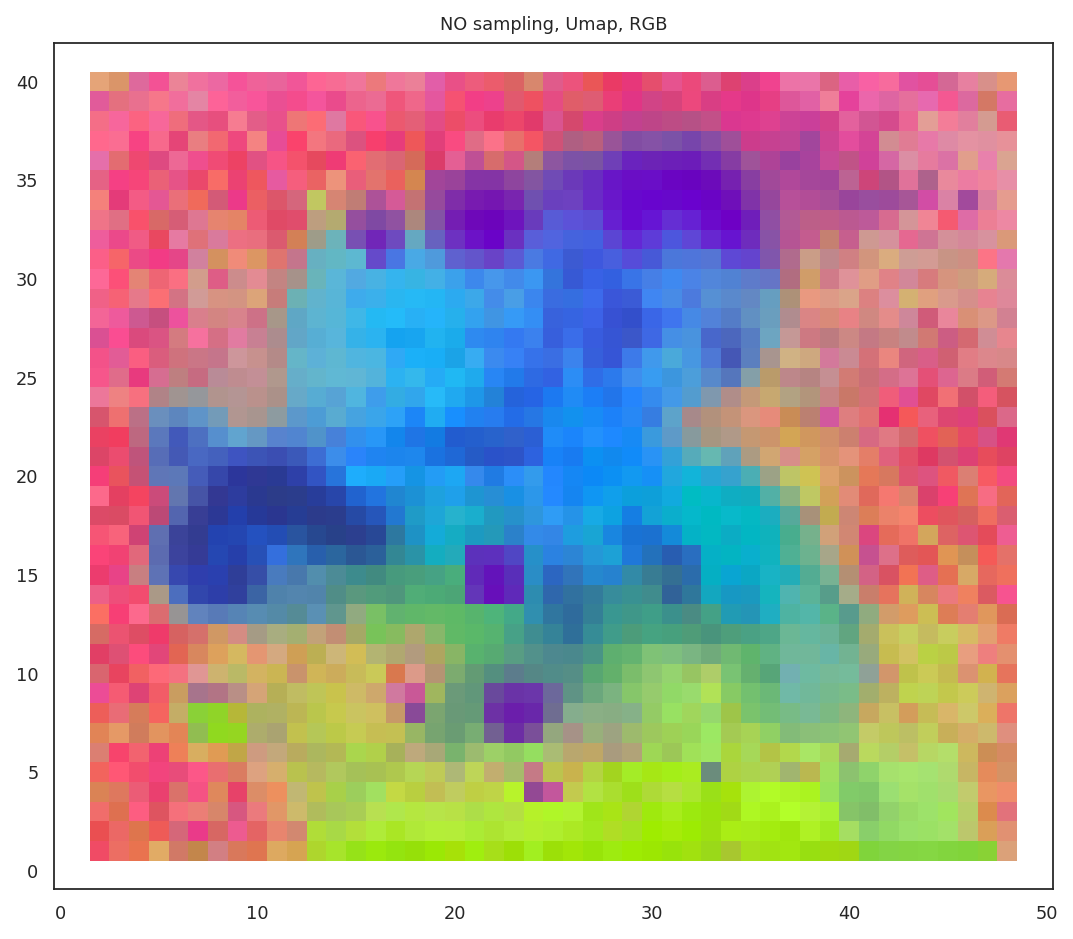

In [71]:
adata_use = adata_valid
pca = 100
dot_size=80
marker='s'
plot_cluster=None
save='{0}/{1}'.format(output_view_folder,data_name)
SOViewer_UMAP(adata_use,pca,dot_size,marker,plot_cluster,save)

In [10]:
intensities.shape

(225,)

In [50]:
p.getspectrum(0)[1]

array([8.35816803e+01, 8.52928696e+01, 8.81367111e+01, 9.02030869e+01,
       9.22015991e+01, 3.54845154e+02, 6.28779785e+02, 2.53004135e+02,
       2.46541382e+02, 1.51797791e+02, 5.02886139e+02, 9.03521194e+01,
       1.95823730e+02, 9.13401489e+01, 8.62796097e+01, 9.16223602e+01,
       8.58931458e+02, 7.60328064e+01, 1.01281937e+02, 8.07940826e+01,
       1.14647224e+02, 1.12971893e+02, 9.04947662e+01, 9.81143265e+01,
       8.99848862e+01, 8.32235336e+01, 9.13615036e+01, 7.93496933e+01,
       9.37091904e+01, 6.02585498e+03, 1.53769385e+03, 1.56418900e+02,
       3.14265564e+02, 3.19526733e+02, 9.09402405e+02, 1.09017456e+02,
       1.81106396e+03, 2.80972626e+02, 1.40034088e+02, 8.94256592e+01,
       1.15798637e+02, 1.66212311e+02, 9.12937012e+01, 8.22179794e+01,
       8.72861176e+01, 9.74002838e+01, 1.06966522e+02, 1.03623352e+02,
       6.17313354e+02, 9.10585938e+01, 6.72217163e+02, 1.05242798e+02,
       3.06798950e+02, 3.17405548e+02, 3.43652527e+02, 2.85368073e+02,
      

In [52]:
np.unique(mzs_list).shape

(330059,)

In [38]:
p.mzLengths

[380,
 269,
 308,
 308,
 295,
 284,
 524,
 254,
 246,
 257,
 255,
 242,
 195,
 165,
 191,
 192,
 207,
 182,
 183,
 188,
 192,
 163,
 186,
 190,
 165,
 179,
 192,
 206,
 173,
 202,
 186,
 205,
 203,
 198,
 206,
 168,
 214,
 189,
 165,
 176,
 397,
 311,
 355,
 381,
 306,
 356,
 285,
 269,
 457,
 271,
 272,
 297,
 344,
 293,
 306,
 263,
 283,
 316,
 281,
 267,
 171,
 161,
 150,
 173,
 148,
 155,
 165,
 135,
 165,
 151,
 139,
 160,
 188,
 194,
 154,
 185,
 167,
 197,
 177,
 221,
 198,
 201,
 187,
 211,
 177,
 165,
 186,
 206,
 247,
 283,
 277,
 249,
 264,
 269,
 346,
 259,
 518,
 278,
 336,
 282,
 284,
 273,
 275,
 282,
 295,
 295,
 253,
 234,
 183,
 205,
 162,
 169,
 181,
 177,
 175,
 163,
 151,
 183,
 146,
 189,
 228,
 153,
 192,
 210,
 146,
 229,
 183,
 178,
 232,
 170,
 183,
 179,
 200,
 187,
 214,
 257,
 257,
 266,
 313,
 255,
 215,
 249,
 344,
 273,
 482,
 314,
 276,
 289,
 327,
 271,
 307,
 221,
 284,
 305,
 258,
 201,
 163,
 178,
 163,
 174,
 198,
 145,
 198,
 179,
 177,
 203,
 190